In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import os

# Replace the origin string with your specific WebSocket origin to allow use of the Phoenix dashboard
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "0klvo4n67bg2u6fr7kngsi6ip1kop1nps068mq9f8l8tfo4s604b"

import warnings

import astropy.units as u
from astropy.modeling import models
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList

from tqdm import tqdm

from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid
from muler.hpf import HPFSpectrumList
from specutils import SpectralRegion
from specutils.manipulation import extract_region
from specutils.fitting import find_lines_derivative, fit_continuum

from scipy.signal import savgol_filter
# %config InlineBackend.figure_format='retina'

from astropy.io import fits

# Plotting Parameters
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\standard_table_v3.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA
# just a pick a sequence of standards to look at: ["LkCa1","HBC427","Hubble4","Anon1","LkCa5","MHO8"])]
# Symposium sequence: ["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"]
# standard_table = standard_table[standard_table['Name'].isin(["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"])].reset_index(drop=True)

proto_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\protostar_table.txt', index_col=0)

standards_path = standard_table['File']
standard_list = standard_table['File'].values

proto_path = proto_table['File']
proto_list = proto_table['File'].values

In [26]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

na_reg_lines = sorted([lines_table[na1_mask][0]['Observed'],
                lines_table[sc1_mask][19]['Observed'],
                lines_table[si1_mask][2]['Observed'],
                lines_table[sc1_mask][20]['Observed'],
                lines_table[na1_mask][1]['Observed']])

na_reg_names = [lines_table[sc1_mask][19]['Spectrum'],
                lines_table[na1_mask][0]['Spectrum'],
                lines_table[si1_mask][2]['Spectrum'],
                lines_table[sc1_mask][20]['Spectrum'],
                lines_table[na1_mask][1]['Spectrum']]

na_reg_lines = np.array(na_reg_lines)

ti_reg_lines = np.array([lines_table[ti1_mask]['Observed'][44],
        lines_table[ti1_mask]['Observed'][45],
        lines_table[fe1_mask]['Observed'][85],
        lines_table[fe1_mask]['Observed'][86],
        lines_table[ti1_mask]['Observed'][47]])

ca_reg_lines = list(lines_table[ca1_mask]['Observed'][:]) # list of Ca I lab wavelengths
ca_reg_lines.append(lines_table[fe1_mask]['Observed'][104])
ca_reg_lines = np.array(sorted(ca_reg_lines))

In [4]:
wavmin = int(2.075*1e4)
wavmax = int(2.289*1e4)

# PHOENIX MODELS

In [5]:
phoenix_mod_path = "C:\\Users\\Savio\\Documents\\Research\\phoenix_models\\phoenix.astro.physik.uni-goettingen.de\\HiResFITS\\"

In [6]:
# spec_list = []
# for i in tqdm(range(len(standard_table))):
#     spec = IGRINSSpectrumList.read(standard_table['File'][i])\
#         .trim_overlap().stitch()
#     # spec = spec[10:-5]
#     spec = spec.apply_boolean_mask(mask=(~np.isnan(spec.flux.value)) & 
#                                     (spec.wavelength.value > wavmin) & 
#                                     (spec.wavelength.value < wavmax)
#                                     ).normalize().remove_nans()#.smooth_spectrum(bandwidth=10)
#     # spec_list.append(spec)
#     spec_list.append(spec.normalize())
#     # spec[15].plot()

In [7]:
proto_spec_list = []
for i in tqdm(range(len(proto_table))):
    proto_spec = IGRINSSpectrumList.read(proto_table['File'][i])\
        .trim_overlap().stitch()
    # spec = spec[10:-5]
    proto_spec = proto_spec.apply_boolean_mask(mask=(np.isfinite(proto_spec.flux.value)) & 
                                    (proto_spec.wavelength.value > wavmin) & 
                                    (proto_spec.wavelength.value < wavmax))
    #                                 ).normalize()#.smooth_spectrum(bandwidth=10)

    proto_spec_list.append(proto_spec.normalize().remove_nans())

100%|██████████| 48/48 [00:14<00:00,  3.30it/s]


In [8]:
def calculate_resolution(spectrum):
    # Extract the wavelength array (in the same units as the input)
    wavelength = spectrum.spectral_axis.value  # Get wavelength in its native units

    # Compute the average delta_lambda (assuming roughly uniform sampling)
    delta_lambda = np.median(np.diff(wavelength, n=1))

    # Compute the average lambda for the spectrum
    lam0 = np.median(wavelength)

    scale_factor = 2.355
    # sigma = delta_lam / scale_factor / angstroms_per_pixel
    
    # Calculate the resolution
    resolution = lam0 / delta_lambda
    
    return resolution

In [9]:
calculate_resolution(proto_spec_list[0])

np.float64(148004.04405132067)

In [10]:
# for i in range(len(proto_spec_list)):
#     print(np.median(np.diff(proto_spec_list[i].wavelength.value)), np.median(proto_spec_list[i].wavelength.value))

In [11]:
# for i in range(len(proto_spec_list)):
#    print(calculate_resolution(proto_spec_list[i]))

In [12]:
# for i in range(len(proto_spec_list)):
#     fig = plt.figure(figsize=(15,5))
#     plt.plot(proto_spec_list[i].wavelength, proto_spec_list[i].flux,
#             c='k', label=f"{proto_table['Name'][i]}", lw=0.5
#         )
#     plt.legend()
#     plt.title(f"{i}")
# plt.show()

# Use PHOENIX Dashboard to manually fit T_eff (and log g?)

In [13]:
# relatively good protostars: 4,5,7,9,10,11,12,13,15,16,17,18,21,22,24,26,27,29,31,33,34,39,42,43,46
# rough Temperature guess: 3500,4500,?,?,4000,4100,4000,
spectrum_n = 45 # index for spec_list (list of Spectrum1D objects)
teff_min, teff_max = 2300, 5300
logg_min, logg_max = 2,6

grid = PHOENIXGrid(teff_range=(teff_min, teff_max),
                   logg_range=(logg_min, logg_max),
                   Z_range=(0,0.5),
                   wl_lo=wavmin,
                   wl_hi=wavmax,
                   path=phoenix_mod_path,
                   instrumental_resolution=45000
                  )

Processing Teff=5800K|log(g)=6.00|Z=+0.5: 100%|██████████| 648/648 [00:28<00:00, 22.63it/s]


In [15]:
# relatively good protostars: 4,5,7,9,11,12,13,15,16,17,18,21,22,24,26,27,29,31,33,34,39,42,43,46
# rough Temperature guess: 3500,4500,?,?,4100,4000,

grid.show_dashboard(proto_spec_list[spectrum_n])

# Try to fit parameters programatically

In [16]:
vsinis = np.linspace(20, 50, 25)
rvs = np.linspace(20, 40, 25)
# try to add veiling?
veil_grid = np.arange(0,4,0.25)

search_vsini, search_rv, search_rk = np.meshgrid(vsinis, rvs, veil_grid, indexing='ij')

@np.vectorize
def chi_squared_vels(spectrum, teff_guess, logg_guess, vsini, rv, r_k, spec_res):
    '''
    spectrum = index in spec_list
    teff_guess = float, must be in steps of 100 K from 2300-7000 K, 200 K after that
    logg_guess = float, must be in steps of 0.5 from 0-6
    vsini = float
    rv = float
    
    '''
    model = PHOENIXSpectrum(teff=teff_guess,
                            logg=logg_guess,
                            Z=0,
                            wl_lo=wavmin,
                            wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).rotationally_broaden(vsini)\
                            .rv_shift(rv)\
                            .resample(proto_spec_list[spectrum])\
                            .normalize()\
                            .instrumental_broaden(spec_res)

    # Flux and uncertainties
    veil_factor = (1+r_k)
    observed_flux = proto_spec_list[spectrum].flux
    model_flux = model.flux * veil_factor
    uncertainty = proto_spec_list[spectrum].uncertainty.array  # Array of flux uncertainties
    
    # Compute chi-squared
    chi_squared = np.nansum((observed_flux - model_flux)**2 / model_flux)
    return chi_squared

In [18]:
t_guess = (np.round(standard_table['PM_Teff']/100)*100) # list of initial guesses for Temperature based on spectral type
proto_t_guess = 4100 # initial guess for Teff based on vibes
logg_guess = 4.5 # initial guess for log g based on vibes

# calculate the chi-squared along each grid point
vel_chi2_grid = chi_squared_vels(spectrum_n,
                             proto_t_guess,
                             logg_guess,
                             search_vsini,
                             search_rv,
                             search_rk,
                             45000
                             )
# find the index for the best fitting vsini and r_v
min_index = np.unravel_index(np.argmin(vel_chi2_grid), vel_chi2_grid.shape)
best_vsini = search_vsini[min_index]
best_rv = search_rv[min_index]
best_rk = search_rk[min_index]
# print(rf"$\chi^2 =$ {chi2_grid[min_index]}")
print(f"Best vsini: {best_vsini}, Best RV: {best_rv}, Best r_k: {best_rk}")

Best vsini: 50.0, Best RV: 34.16666666666667, Best r_k: 0.0


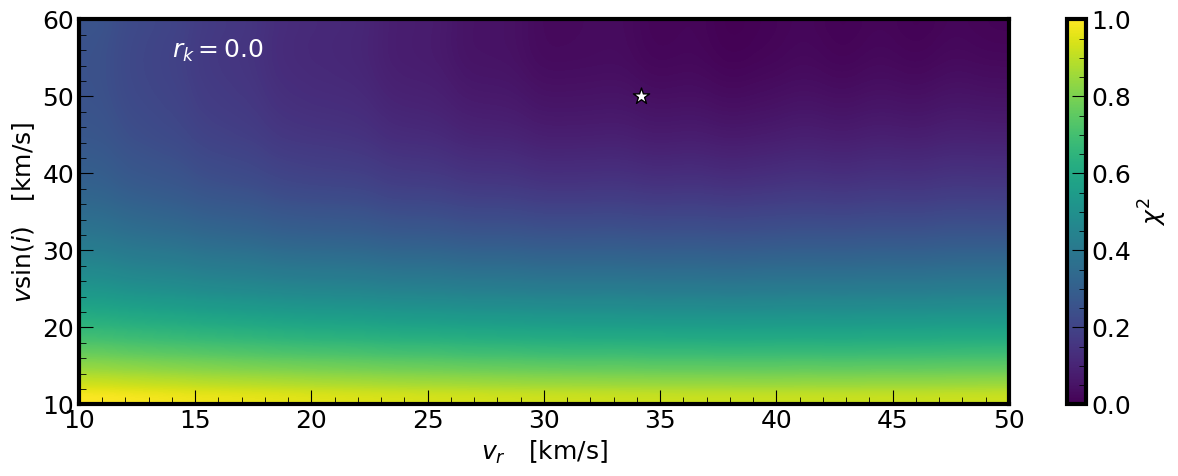

In [ ]:
plt.imshow(vel_chi2_grid[:,:,min_index[2]], extent=[rvs.min()-5, rvs.max()+5, vsinis.min()-5, vsinis.max()+5],
           aspect='auto',
           origin='lower',
           interpolation='gaussian'
           )
plt.scatter(best_rv, best_vsini, marker='*', c='w', ec='k', s=150)

# Add text using fraction of axes coordinates
ax = plt.gca()  # Get current axes
ax.text(0.1, 0.9, f"$r_k = {best_rk:.1f}$", transform=ax.transAxes, c='w', fontsize=18)

plt.colorbar(label=r'$\chi^2$')
plt.xlabel(r'$v_r \quad [\mathrm{km}/\mathrm{s}]$')
plt.ylabel(r'$v\sin(i) \quad [\mathrm{km} / \mathrm{s}]$')

plt.show()

In [20]:
@np.vectorize
def chi_squared_tg(spectrum, teff, logg, vsini, rv, r_k, spec_res):
    '''
    spectrum = index in spec_list
    teff_guess = float, must be in steps of 100 K from 2300-7000 K, 200 K after that
    logg_guess = float, must be in steps of 0.5 from 0-6
    vsini = float
    rv = float
    
    '''
    model = PHOENIXSpectrum(teff=teff,logg=logg,Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).rotationally_broaden(vsini)\
                            .rv_shift(rv)\
                            .resample(proto_spec_list[spectrum])\
                            .normalize()\
                            .instrumental_broaden(spec_res)

    # Flux and uncertainties
    veil_factor = (1+r_k)
    observed_flux = proto_spec_list[spectrum].flux
    model_flux = model.flux * veil_factor
    uncertainty = proto_spec_list[spectrum].uncertainty.array  # Array of flux uncertainties
    
    # Compute chi-squared
    chi_squared = np.nansum((observed_flux - model_flux)**2 / model_flux)
    return chi_squared

In [ ]:
teff_grid = np.arange(teff_min,teff_max+100,100) # initial guess for Teff based on vibes
logg_grid = np.arange(2,6,0.5) # initial guess for log g based on vibes

search_teff, search_logg, search_rk = np.meshgrid(teff_grid, logg_grid, veil_grid, indexing='ij')

# calculate the chi-squared along each grid point
tg_chi2_grid = chi_squared_tg(spectrum_n,
                             search_teff,
                             search_logg,
                             best_vsini,
                             best_rv,
                             search_rk,
                             45000
                             )
# find the index for the best fitting vsini and r_v
min_index = np.unravel_index(np.argmin(tg_chi2_grid), tg_chi2_grid.shape)
best_teff = search_teff[min_index]
best_logg = search_logg[min_index]
best_rk = search_rk[min_index]
# print(rf"$\chi^2 =$ {chi2_grid[min_index]}")
print(rf"Best T_{{\rm eff}}: {best_teff}, Best $\log g$: {best_logg}, Best r_k: {best_rk}")

Best T_{\rm eff}: 3200, Best $\log g$: 4.5, Best r_k: 0.0


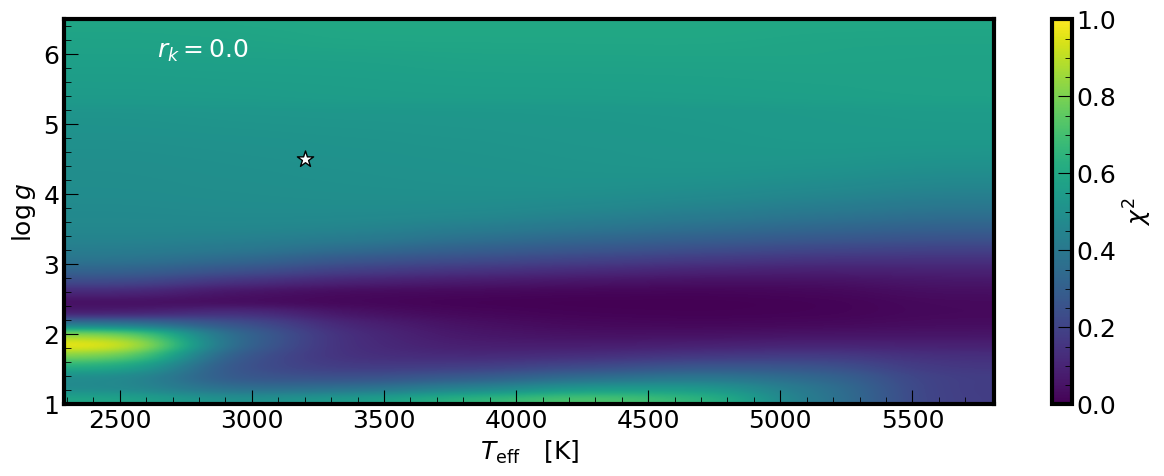

In [22]:
plt.imshow(tg_chi2_grid[:,:,min_index[2]], extent=[teff_grid.min()-10, teff_grid.max()+10, logg_grid.min()-1, logg_grid.max()+1],
           aspect='auto',
           origin='lower',
           interpolation='gaussian'
           )
plt.scatter(best_teff, best_logg, marker='*', c='w', ec='k', s=150)

# Add text using fraction of axes coordinates
ax = plt.gca()  # Get current axes
ax.text(0.1, 0.9, f"$r_k = {best_rk:.1f}$", transform=ax.transAxes, c='w', fontsize=18)

plt.colorbar(label=r'$\chi^2$')
plt.xlabel(r'$T_{\rm eff} \quad [\rm K]$')
plt.ylabel(r'$\log g$')

plt.show()

In [24]:
# best_spec = PHOENIXSpectrum(teff=proto_t_guess, logg=logg_guess, Z=0,
#                             wl_lo=wavmin,wl_hi=wavmax,
#                             path=phoenix_mod_path
#                             ).resample(proto_spec_list[spectrum_n])\
#                             .tilt_to_data(proto_spec_list[spectrum_n])\
#                             .instrumental_broaden(resolving_power=45000)\
#                             .normalize().rotationally_broaden(best_vsini).rv_shift(best_rv)
# proto_t_guess = 3500
# logg_guess = 3.0
best_spec = PHOENIXSpectrum(teff=best_teff, logg=best_logg, Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).resample(proto_spec_list[spectrum_n])\
                            .tilt_to_data(proto_spec_list[spectrum_n])\
                            .rotationally_broaden(best_vsini).rv_shift(best_rv)

# veil_spec = Spectrum1D(flux=(best_spec.flux + best_rk) / (1+best_rk),spectral_axis=best_spec.wavelength)
# best_spec = veil_spec.tilt_to_data(proto_spec_list[spectrum_n])

model_tdiff_spec = PHOENIXSpectrum(teff=best_teff+300, logg=best_logg, Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).resample(proto_spec_list[spectrum_n])\
                            .tilt_to_data(proto_spec_list[spectrum_n])\
                            .rotationally_broaden(best_vsini).rv_shift(best_rv)

model_gdiff_spec = PHOENIXSpectrum(teff=best_teff, logg=best_logg+0.5, Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).resample(proto_spec_list[spectrum_n])\
                            .tilt_to_data(proto_spec_list[spectrum_n])\
                            .rotationally_broaden(best_vsini).rv_shift(best_rv)

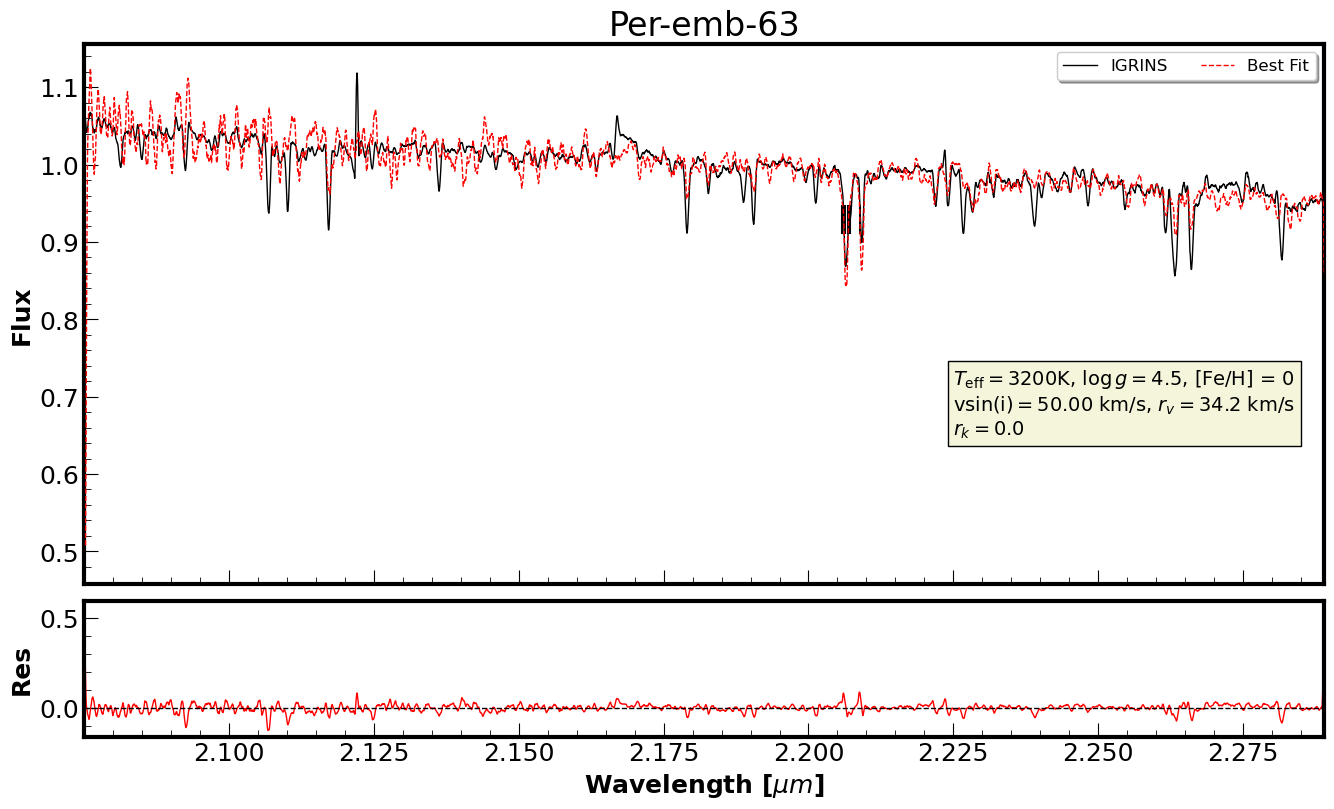

In [36]:
# smooth protostar spectrum to remove spikes
smoothed_flux = savgol_filter(proto_spec_list[spectrum_n].flux.value , window_length=51, polyorder=3)

# veiled model flux
veil_flux = (best_spec.flux + best_rk) / (1+best_rk)
# Compute residuals: observed flux - model flux
residuals = smoothed_flux - veil_flux

from matplotlib.gridspec import GridSpec

# Set up a figure with two panels (one for spectrum, one for residuals)
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(2, 1, height_ratios=[4, 1], hspace=0.05)  # GridSpec for proportional heights

ax0 = fig.add_subplot(gs[0])
ax0.plot(proto_spec_list[spectrum_n].wavelength*1e-4, smoothed_flux, # proto_spec_list[spectrum_n].flux
         lw=1,color='k',label=rf"IGRINS",zorder=1, # $\pm 3 \sigma$
         )

ax0.plot(best_spec.wavelength*1e-4, veil_flux, # best_spec.flux
        lw=1, ls='--', color='r', label='Best Fit', zorder=5
        )

# ax0.plot(model_tdiff_spec.wavelength*1e-4, model_tdiff_spec.flux,
#          lw=1, ls='-.', color='g', label=r'Best Fit$\plus 300$ K', zorder=4
#         )
# ax0.plot(model_gdiff_spec.wavelength*1e-4, model_gdiff_spec.flux,
#          lw=1, ls=':', color='b', label=r'Best Fit$\plus 0.5 \, \log g$', zorder=3
#         )
         

# Add text for parameters
ax0.text(2.2250, 0.65, rf'$T_{{\rm eff}}=${best_teff:.0f}K, $\log g =${best_logg}, [Fe/H] = 0' '\n' 
         rf'$\rm v\sin(\rm i)=${best_vsini:.2f} km/s, $r_v=${best_rv:.1f} km/s' '\n'
         rf'$r_k=${best_rk:.1f}',
         color='black', bbox=dict(facecolor='beige', edgecolor='black', boxstyle='square,pad=0.3'),
         fontsize=14
         )

# Label Features
# ax0.text(2.155,1.55,r'$\rm Br\gamma$') # Br-Gamma

for i in range(len(na_reg_lines)):
    ax0.axvline(na_reg_lines[i], ymin=0.65, ymax=0.7, ls='-', color='black', lw=1.5)
#     ax0.text(na_reg_lines[i], 1.55-(0.05*i), f'{na_reg_names[i]}', color='black', fontsize=12)

ax0.set_xlim(np.min(proto_spec_list[spectrum_n].wavelength.value)*1e-4 , np.max(proto_spec_list[spectrum_n].wavelength.value)*1e-4)
# ax0.set_xlim(2.26,2.267)
# ax0.set_ylim(bottom=0.6)
ax0.set_ylabel('Flux')
# Title and legend
ax0.set_title(f"{proto_table['Name'][spectrum_n].replace('_', ' ')}")
# legend with each set of data in one row
ax0.legend(fontsize=12, frameon=True, shadow=True, loc='best', ncol=4)

# Remove x-axis ticks for upper plot (shared axis with residuals)
ax0.tick_params(axis='x', labelbottom=False)  # Hides x-tick labels for the top panel only

# ---- Lower Panel: Residuals ----
ax1 = fig.add_subplot(gs[1], sharex=ax0)  # Share x-axis with the spectrum plot
ax1.plot(proto_spec_list[spectrum_n].wavelength*1e-4, residuals, lw=1, color='r', label='Residuals')
ax1.axhline(0, color='k', linestyle='--', lw=1)  # Add horizontal line at zero for reference

# ax1.set_xlim(2.2)
# ax1.set_ylim(-0.15, 0.15)
# Labels for residuals plot
ax1.set_xlabel('Wavelength [$\mu m$]')
ax1.set_ylabel('Res')

# plt.xlim(2.1200, 2.2500)
# Tight layout and show plot
# plt.tight_layout()
plt.show()